In [8]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import cPickle as pickle
from copy import deepcopy
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [2]:
train_graphs = pickle.load(open("train-freq-graphs.pkl",'r'))
train_labels = pickle.load(open("train-freq-labels.pkl",'r'))

In [3]:
import sklearn_mmadsen as skm

Using gpu device 0: GeForce GT 650M (CNMeM is disabled)
/Users/mark/anaconda/lib/python2.7/site-packages/Theano-0.8.0.dev0-py2.7.egg/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


Using Theano backend.


In [4]:
gclf = skm.GraphEigenvalueNearestNeighbors(n_neighbors=5)

In [5]:
def leave_one_out_cv(ix, train_graphs, train_labels):
    """
    Simple LOO data sets for kNN classification, given an index, returns a train set, labels, with the left out 
    graph and label as test_graph, test_label
    """
    test_graph = train_graphs[ix]
    test_label = train_labels[ix]
    train_loo_graphs = deepcopy(train_graphs)
    train_loo_labels = deepcopy(train_labels)
    del train_loo_graphs[ix]
    del train_loo_labels[ix]
    return (train_loo_graphs, train_loo_labels, test_graph, test_label)

In [6]:
test_pred = []
for ix in range(0, len(train_graphs)):
    train_loo_graphs, train_loo_labels, test_graph, test_label = leave_one_out_cv(ix, train_graphs, train_labels)
    gclf.fit(train_loo_graphs, train_loo_labels)
    test_pred.append(gclf.predict([test_graph])[0])
    

In [10]:
cm = confusion_matrix(train_labels, test_pred)
cmdf = pd.DataFrame(cm)
cmdf.columns = map(lambda x: 'predicted {}'.format(x), cmdf.columns)
cmdf.index = map(lambda x: 'actual {}'.format(x), cmdf.index)

print cmdf
print(classification_report(train_labels, test_pred))
print("Accuracy on test: %0.3f" % accuracy_score(train_labels, test_pred))

          predicted 0  predicted 1
actual 0           41            9
actual 1           14           35
             precision    recall  f1-score   support

          0       0.75      0.82      0.78        50
          1       0.80      0.71      0.75        49

avg / total       0.77      0.77      0.77        99

Accuracy on test: 0.768


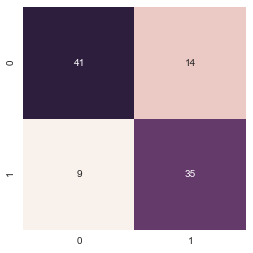

In [11]:
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False)

In [ ]:
# first 150 rows are linear

In [14]:
knn = [1, 3, 5, 7, 9, 11, 15]
for nn in knn:
    gclf = skm.GraphEigenvalueNearestNeighbors(n_neighbors=nn)
    test_pred = []
    for ix in range(0, len(train_graphs)):
        train_loo_graphs, train_loo_labels, test_graph, test_label = leave_one_out_cv(ix, train_graphs, train_labels)
        gclf.fit(train_loo_graphs, train_loo_labels)
        test_pred.append(gclf.predict([test_graph])[0])
    print("Accuracy on test for %s neighbors: %0.3f" % (nn, accuracy_score(train_labels, test_pred)))
    

Accuracy on test for 1 neighbors: 0.788
Accuracy on test for 3 neighbors: 0.798
Accuracy on test for 5 neighbors: 0.768
Accuracy on test for 7 neighbors: 0.747
Accuracy on test for 9 neighbors: 0.758
Accuracy on test for 11 neighbors: 0.788
Accuracy on test for 15 neighbors: 0.788
